In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
input_data_raw1 = np.loadtxt('input_data_save.txt')
cap_data_raw1 = np.loadtxt('cap_data_save.txt')

In [4]:
# Convert the training data to PyTorch tensors
x_train_tensor_raw = torch.tensor(input_data_raw1, dtype=torch.float32)
y_train_tensor_raw = torch.tensor(cap_data_raw1, dtype=torch.float32)

In [5]:
def normalize_tensor(tensor, max_val, min_val):
    return (tensor - min_val) / (max_val - min_val)

x_train_epsneg_raw1 = x_train_tensor_raw[:, 0]
x_train_epspos_raw1 = x_train_tensor_raw[:, 1]

max_epsneg = torch.max(x_train_epsneg_raw1)
min_epsneg = torch.min(x_train_epsneg_raw1)

max_epspos = torch.max(x_train_epspos_raw1)
min_epspos = torch.min(x_train_epspos_raw1)

x_train_epsneg_norm1 = normalize_tensor(x_train_epsneg_raw1, max_epsneg, min_epsneg)
x_train_epspos_norm1 = normalize_tensor(x_train_epspos_raw1, max_epspos, min_epspos)
x_train = torch.stack((x_train_epsneg_norm1, x_train_epspos_norm1), dim=1)

y_train_tensor = y_train_tensor_raw
max_y = torch.max(y_train_tensor)
min_y = torch.min(y_train_tensor)

y_train_norm = normalize_tensor(y_train_tensor, max_y, min_y)
y_train = y_train_norm.reshape(200,1)

In [6]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(2, 15)  # Input layer (2 inputs) to first hidden layer (15 neurons)
        self.layer2 = nn.Linear(15, 5)  # First hidden layer (15 neurons) to second hidden layer (5 neurons)
        self.layer3 = nn.Linear(5, 1)   # Second hidden layer (5 neurons) to output layer (1 output)
        
        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Instantiate the model
model = ANN()

# Define the loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [7]:
# Number of epochs for training
num_epochs = 20000

for epoch in range(num_epochs):
    # Forward pass: compute the model output
    outputs = model(x_train)
    
    # Compute the loss
    loss = criterion(outputs, y_train)
    
    # Backward pass: compute the gradients
    optimizer.zero_grad()
    loss.backward()
    
    # Update the weights
    optimizer.step()
    
    # Print the loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/20000], Loss: 0.0498
Epoch [200/20000], Loss: 0.0409
Epoch [300/20000], Loss: 0.0354
Epoch [400/20000], Loss: 0.0318
Epoch [500/20000], Loss: 0.0289
Epoch [600/20000], Loss: 0.0263
Epoch [700/20000], Loss: 0.0239
Epoch [800/20000], Loss: 0.0217
Epoch [900/20000], Loss: 0.0195
Epoch [1000/20000], Loss: 0.0173
Epoch [1100/20000], Loss: 0.0153
Epoch [1200/20000], Loss: 0.0133
Epoch [1300/20000], Loss: 0.0114
Epoch [1400/20000], Loss: 0.0097
Epoch [1500/20000], Loss: 0.0083
Epoch [1600/20000], Loss: 0.0072
Epoch [1700/20000], Loss: 0.0062
Epoch [1800/20000], Loss: 0.0055
Epoch [1900/20000], Loss: 0.0049
Epoch [2000/20000], Loss: 0.0044
Epoch [2100/20000], Loss: 0.0041
Epoch [2200/20000], Loss: 0.0038
Epoch [2300/20000], Loss: 0.0035
Epoch [2400/20000], Loss: 0.0033
Epoch [2500/20000], Loss: 0.0031
Epoch [2600/20000], Loss: 0.0030
Epoch [2700/20000], Loss: 0.0028
Epoch [2800/20000], Loss: 0.0027
Epoch [2900/20000], Loss: 0.0026
Epoch [3000/20000], Loss: 0.0025
Epoch [3100/20000],

In [8]:
# Define the function to optimize
def objective_function(x):
    tensor1 = x[0]    # 1 represents the anode porosity 
    tensor2 = x[1]    # 2 represents the cathode porosity
    x_input = torch.stack((tensor1, tensor2), dim=0)
    return model(x_input)

# Initialize the inputs (parameters to optimize)
val0 = torch.rand(1)    # an initial guess of anode porosity (normalized)
val1 = torch.rand(1)    # an initial guess of cathode porosity (normalized)
x = torch.tensor([val0, val1], requires_grad=True)

# Define the optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD([x], lr=0.01)  # lr is the learning rate

# Number of optimization steps
num_steps = 100

# Lists to store the evolution of x[0], x[1], and loss
x0_values = []
x1_values = []

# Optimization loop
for step in range(num_steps):
    # Zero the gradients from the previous step
    optimizer.zero_grad()

    # Compute the objective function
    result = objective_function(x)
    loss = -result[0]

    # Compute the gradients (backward pass)
    loss.backward()

    # Update the parameters using the optimizer
    optimizer.step()

    # Apply the constraints to keep x[0] and x[1] within [0, 1]
    with torch.no_grad():
        x.clamp_(0, 1)  # In-place operation to clamp x within [0, 1]

    # Store the current values of x[0], x[1], and loss
    x0_values.append(x[0].item())
    x1_values.append(x[1].item())

    # Print the current value of the loss and parameters
    print(f"Step {step + 1}: x = {x.detach().numpy()}, Loss = {loss.item()}")

# Final optimized values
print(f"Optimized x: {x.detach().numpy()}")
print(f"Final Loss: {objective_function(x).item()}")

Step 1: x = [0.7955438  0.87706727], Loss = -0.6840722560882568
Step 2: x = [0.7907853 0.8688451], Loss = -0.6930969953536987
Step 3: x = [0.78602684 0.86062294], Loss = -0.7021217346191406
Step 4: x = [0.78126836 0.8524008 ], Loss = -0.711146354675293
Step 5: x = [0.7765099 0.8441786], Loss = -0.7201710939407349
Step 6: x = [0.7717514  0.83595645], Loss = -0.729195773601532
Step 7: x = [0.7669929 0.8277343], Loss = -0.7382205128669739
Step 8: x = [0.76223445 0.8195121 ], Loss = -0.747245192527771
Step 9: x = [0.757476   0.81128997], Loss = -0.7562700510025024
Step 10: x = [0.7527175 0.8030678], Loss = -0.7652947902679443
Step 11: x = [0.747959   0.79484564], Loss = -0.7743194699287415
Step 12: x = [0.74320054 0.7866235 ], Loss = -0.7833441495895386
Step 13: x = [0.73844206 0.7784013 ], Loss = -0.7923688292503357
Step 14: x = [0.7336836  0.77017915], Loss = -0.8013936877250671
Step 15: x = [0.7289251 0.761957 ], Loss = -0.8104183673858643
Step 16: x = [0.72416663 0.7537348 ], Loss = -0

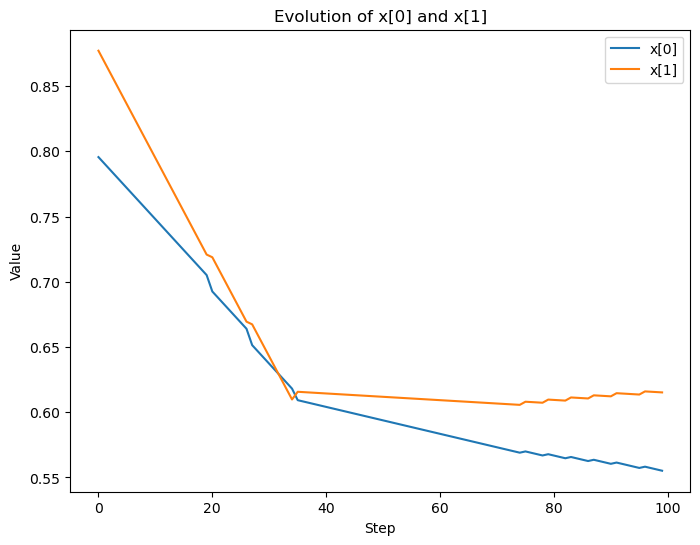

In [9]:
# Plotting the evolution of x[0] and x[1]
plt.figure(figsize=(8, 6))
plt.plot(x0_values, label='x[0]')
plt.plot(x1_values, label='x[1]')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Evolution of x[0] and x[1]')
plt.legend()
plt.show()

In [10]:
# define the de-normalization function
def de_normalize_tensor(tensor, max_val, min_val):
    return tensor * (max_val - min_val) + min_val
    
# de-normalize the porosity of anode and cathode
value_real0 = de_normalize_tensor(x[0], max_epsneg, min_epsneg)
print(value_real0)    # optimized result of anode porosity
value_real1 = de_normalize_tensor(x[1], max_epspos, min_epspos)
print(value_real1)    # optimized result of cathode porosity

# de-normalize the capacity value (C/m^2)
y = model(x)
cap_optim = de_normalize_tensor(y[0], max_y, min_y)
print(cap_optim)

tensor(0.4998, grad_fn=<AddBackward0>)
tensor(0.5293, grad_fn=<AddBackward0>)
tensor(23.2164, grad_fn=<AddBackward0>)
